Import required dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

**Import Data**

File blog.csv contains a normalized rating information on 200 stories from 2000 users.   
The ratings represent how much someone liked a story. There may be different ways to capture this information but for the purpose of this code, we'll assume we have this data available on a normalized scale (0 to 1).    
Not all users have read all stories.  

In [2]:
ratings_df = pd.read_csv('blog.csv', header=None)
print(len(ratings_df))    # Let's see how many rows we have
ratings_df.head()         # Let's print first few rows

119822


,0,1,2
0,0,1,0.301633
1,0,2,0.050480
2,0,4,0.141024
3,0,5,0.240804
4,0,10,0.160070


Let's rename the columns.

In [3]:
ratings_df.columns = ['UserId', 'StoryId', 'Rating']
ratings_df.head()

,UserId,StoryId,Rating
0,0,1,0.301633
1,0,2,0.050480
2,0,4,0.141024
3,0,5,0.240804
4,0,10,0.160070


Now, pivot table to get a **M * K** Matrix.

In [4]:
y_df = ratings_df.pivot_table(index=['StoryId'], columns=['UserId'])
y = np.array(y_df)

y_bool = np.where(np.isnan(y), 0, 1).astype(bool)
y_map = np.where(np.isnan(y), 0, y)

Let's define 3 variables M,N,K
- M = Number of Stories  
- N = Number of Features (We'll assume it to be 20 for now)  
- K = Number of users.

In [5]:
M,K = y_map.shape
N = 20
print(M,'Stories')
print(N,'Features')
print(K,'Users')

200 Stories
20 Features
2000 Users


Set apart 30% of data as testing data and rest is all training data

In [6]:
r = np.random.random([M,K])
y_train_bool = tf.to_float(y_bool * np.greater(r,0.3))
y_test_bool = tf.to_float(y_bool * np.greater(0.3, r))


Let's define x as a feature tensor.   
This is going to be a **M * N** matrix.

For each story - 
We define N features from ($x_1$, $x_2$, ... $x_n$)  

We don't know the features yet, so we'll learn it over time.  
For now, let's assume **small** random values.  

In [7]:
x = tf.Variable(tf.random_uniform([M,N]))/100

Similarly define a weight matrix w for all users.  
This is going to be a **N * K ** matrix.

For each user - what is the weight (liking) towards each of those N features.  

In [8]:
w = tf.Variable(tf.random_uniform([N, K]))/100
b = tf.Variable(tf.random_uniform([K]))/100

Hypothesis (Model).

For now we'll consider a Logistic Regression Model.

$$h = x*w +b $$

In [9]:
h = tf.matmul(x,w) + b

Regularization Parameter to avoid overfitting

In [10]:
lambda_ = tf.to_float(2.5)

Training Cost Function.

$$ J(w,x) = \frac{1}{2}\sum((h-y)^2) + \frac{\lambda}{2}\sum(x^2) + \frac{\lambda}{2}\sum(w^2) $$


In [11]:
cost_function = (
    (0.5)*tf.reduce_sum(y_train_bool * tf.square(h-y_map)) + \
    (lambda_/2)*tf.reduce_sum(tf.square(x)) + \
    (lambda_/2)*tf.reduce_sum(tf.square(w))
) 

Testing Cost Function : 
$$ J(w,x) = \frac{1}{2}\sum((h-y)^2))$$


In [12]:
cost_function_test =  (
  (0.5)*tf.reduce_sum(y_test_bool*tf.square(h-y_map))
)


Define your optimizer.

In [13]:
alpha = tf.placeholder(tf.float32)  # Learning Rate

training_step = tf.train.AdamOptimizer(alpha).minimize(cost_function)

In [14]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Let's begin Training




In [15]:
plot_data = {'c_test' : [], 'c_train' : []}
iters = 1000

for i in range(iters):
    # Exponentially decay learning rate
    max_learning_rate = 1
    min_learning_rate = 0.1
    decay_speed = 50
    learning_rate = min_learning_rate + \
    (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # Optimize
    _, c, ct = sess.run([training_step, cost_function, cost_function_test], {alpha: learning_rate})
    
    # Store cost function for each iteration
    plot_data['c_train'].append(c)
    plot_data['c_test'].append(ct)
    
    # Print occasionally to see progress
    if i%20==0:
        print(i, c, ct)

print("Training Complete")

0 3316.88 1402.09
20 1829.12 767.029
40 1764.61 747.476
60 1730.69 739.34
80 1703.56 737.748
100 1677.65 732.917
120 1651.21 726.639
140 1619.86 717.115
160 1579.69 702.925
180 1533.79 685.251
200 1489.38 667.142
220 1450.81 650.734
240 1418.85 636.59
260 1392.86 624.566
280 1371.9 614.365
300 1355.06 605.7
320 1341.57 598.336
340 1330.83 592.089
360 1322.29 586.799
380 1315.52 582.326
400 1310.12 578.544
420 1305.79 575.351
440 1302.28 572.665
460 1299.42 570.414
480 1297.06 568.539
500 1295.09 566.985
520 1293.44 565.7
540 1292.04 564.638
560 1290.85 563.761
580 1289.84 563.034
600 1288.98 562.43
620 1288.25 561.925
640 1287.62 561.501
660 1287.09 561.144
680 1286.64 560.841
700 1286.26 560.584
720 1285.93 560.366
740 1285.64 560.18
760 1285.4 560.021
780 1285.18 559.886
800 1285.0 559.771
820 1284.83 559.673
840 1284.69 559.59
860 1284.56 559.519
880 1284.44 559.459
900 1284.33 559.409
920 1284.24 559.365
940 1284.15 559.328
960 1284.07 559.296
980 1283.99 559.269
Training Complete


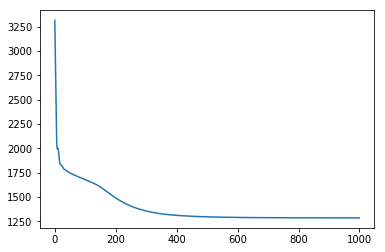

In [16]:
# Plotting Training Error Chart
plt.plot(range(iters), plot_data['c_train'])
plt.show()

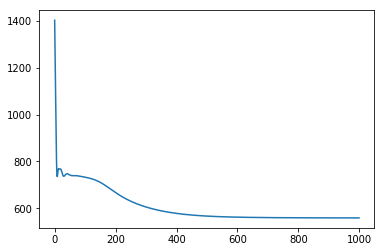

In [17]:
# Plotting Testing Error Chart
plt.plot(range(iters), plot_data['c_test'])
plt.show()

**Prediction**

Run the model on the 30% data that we had set aside.

Take the predicted and the real values for the same set of data and plot to see how close are we.

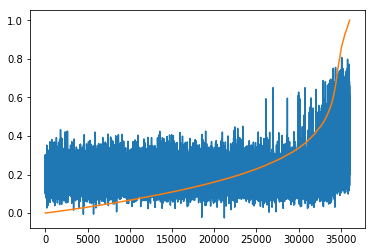

In [18]:
evaluated_y_test_bool, predicted = sess.run([y_test_bool, h])
evaluated_y_test_bool = evaluated_y_test_bool.astype(bool)

predicted = predicted*evaluated_y_test_bool
real = y_map*evaluated_y_test_bool

predicted = predicted[predicted.nonzero()]
real = real[real.nonzero()]

yi = np.lexsort((predicted, real))

predicted, real = predicted[yi], real[yi]

plt.plot(range(len(predicted)), predicted)
plt.plot(range(len(real)), real)
plt.show()

The orange line here is a set of real ratings from the data.  
The blue line is the predicted ratings.  
Although we are not very close, you can see that the model has started following the trend of the curve.

***We can say that the model has started to learn.***

This is a very simple collabrative filtering algorithm in which we learn both the features as well as weights and biases using a very simple linear regression based model.

This can further be enhanced to use more complicated models of higher order or even Neural Networks.